# Section IV - MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from matplotlib import offsetbox
from sklearn.utils import shuffle
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans

## A. The dataset

### Description
The MNIST-dataset is 



In [3]:
# Loading dataset

# small dataset 1797 samples with 8x8=64 dim
#digits = datasets.load_digits(n_class=10)
# or
# original dataset 70.000 samples with 28x28=784 dim
digits = datasets.fetch_mldata('MNIST original', data_home="mnist")
inputs = digits.data
targets = digits.target
n_samples, n_features = inputs.shape
n_neighbors = 30
pixel_width = int(np.sqrt(inputs.shape[1]))

# shuffle data
inputs, targets = shuffle(inputs, targets, random_state=123)

print("Xshape: ", inputs.shape)
print("yshape: ", targets.shape)


Xshape:  (70000, 784)
yshape:  (70000,)


In [4]:
digits.data.imag[2].shape

(784,)

### Insight in the dataset

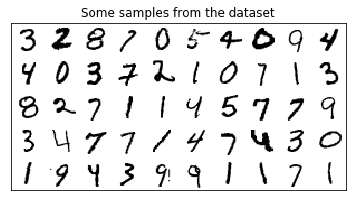

In [5]:
nb_images_per_row = 10
nb_images_per_col = 5
image = np.zeros(((pixel_width+2)*nb_images_per_col, (pixel_width+2)*nb_images_per_row))

for i in range(nb_images_per_col):
    x = (pixel_width+2)*i + 1
    
    for j in range (nb_images_per_row):
        y = (pixel_width+2)*j + 1
        image[x:x+pixel_width, y:y+pixel_width] = inputs[i*nb_images_per_row + j].reshape((pixel_width,pixel_width))
        
plt.imshow(image, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title("Some samples from the dataset")
plt.show()

As you can see this is the dataset input is a picture with 8x8 pixels. low resolution

Next we will look as some local variation in the data within the same classes/digits

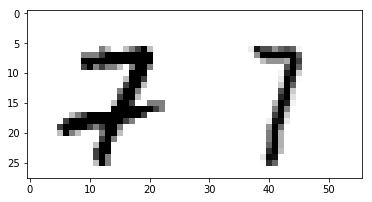

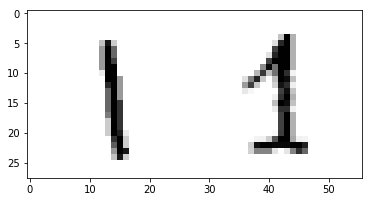

In [6]:
def get_X_with_label(label):
    y_bool = np.equal(targets,label)
    X_label = inputs[y_bool]
    return X_label

X_7 = get_X_with_label(7)

plt.imshow(np.hstack((X_7[1].reshape((pixel_width,pixel_width)), X_7[2].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

X_1 = get_X_with_label(1)

plt.imshow(np.hstack((X_1[1].reshape((pixel_width,pixel_width)), X_1[316].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

Here we can see some of the variations one could expect from handwritten digits. There are different types of writing. The seven can be written with or without a crossbar at the top image. Some ones are written with a bottom crossbar like the one to right some are not. These are just one of the variations we can occur in the 

## B. LLE

In [135]:
print("Computing LLE embedding")
nb_components = 2
nb_neighbors =30
lle = manifold.LocallyLinearEmbedding(nb_neighbors, nb_components,
                                      method='standard')
X_lle = lle.fit_transform(inputs[0:5000])
print("Done. Reconstruction error: %g" % lle.reconstruction_error_)

Computing LLE embedding
Done. Reconstruction error: 0.000104368


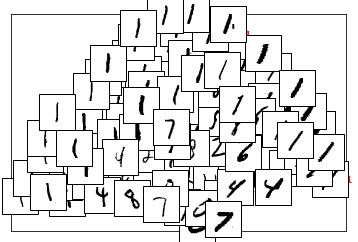

In [175]:

plot_embedding(X_lle, targets[0:5000])
plt.show()

We can see it discover some of the underlying structure in how we are writing the digits, but it is rather bad at finding the semantic value up the semantic

In [14]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(int(y[i])),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    """
    # the pictures are too big
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[0.1, 0.1]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(inputs[i].reshape((int(np.sqrt(inputs.shape[1])),int(np.sqrt(inputs.shape[1])))), cmap=plt.cm.gray_r),
            X[i])
            ax.add_artist(imagebox)
    """
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Finding optimal parameters
- heatmap with nb_neighbors and regr.value with accuracy in each point


In [49]:
grid_width = 10
nb_clusters = 10
nb_components = 2
nb_samples = 500
reg_space=np.logspace(-14,10,grid_width)
neighbor_space = np.linspace(start=3, stop=40, num=grid_width, endpoint=False, dtype=int)

acc_list = np.zeros((grid_width,grid_width))

for i, nb_neighbors in enumerate(neighbor_space):
    for j, reg_term in enumerate(reg_space):
        
    
        lle = manifold.LocallyLinearEmbedding(nb_neighbors, nb_components, reg=reg_term,
                                              method='standard')
        X_lle = lle.fit_transform(inputs[0:nb_samples])

        kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, random_state=123).fit(X_lle)
        acc = metrics.accuracy_score(targets[0:nb_samples], kmeans.labels_)
        acc_list[i, j] = acc


In [50]:
acc_list

array([[ 0.078,  0.078,  0.002,  0.15 ,  0.094,  0.092,  0.152,  0.194,
         0.042,  0.048],
       [ 0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.14 ,  0.044,  0.056,  0.174,
         0.05 ,  0.024],
       [ 0.028,  0.028,  0.028,  0.028,  0.036,  0.058,  0.026,  0.026,
         0.026,  0.026],
       [ 0.124,  0.108,  0.124,  0.124,  0.144,  0.102,  0.178,  0.074,
         0.074,  0.084],
       [ 0.136,  0.136,  0.122,  0.136,  0.046,  0.054,  0.06 ,  0.068,
         0.132,  0.13 ],
       [ 0.13 ,  0.13 ,  0.072,  0.13 ,  0.17 ,  0.056,  0.16 ,  0.212,
         0.114,  0.208],
       [ 0.114,  0.114,  0.114,  0.114,  0.06 ,  0.086,  0.048,  0.1  ,
         0.048,  0.13 ],
       [ 0.072,  0.162,  0.162,  0.17 ,  0.196,  0.162,  0.092,  0.04 ,
         0.15 ,  0.06 ],
       [ 0.116,  0.116,  0.116,  0.116,  0.186,  0.124,  0.038,  0.11 ,
         0.034,  0.082],
       [ 0.078,  0.078,  0.078,  0.036,  0.144,  0.052,  0.044,  0.166,
         0.052,  0.106]])

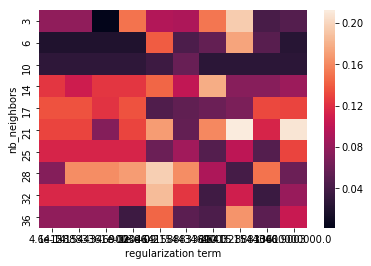

In [51]:
ax = sns.heatmap(acc_list)
ax.set_xlabel("regularization term")
ax.set_ylabel("nb_neighbors")
ax.set_xticklabels(reg_space)
ax.set_yticklabels(neighbor_space)
plt.show()

## C. t-sne

In [52]:
nb_samples = 500
tsne = manifold.TSNE(n_components=2, perplexity = 30, early_exaggeration = 4, learning_rate=1000.0, 
                     n_iter=1000, metric='euclidean', init='pca', verbose=0, random_state=0)

X_tsne = tsne.fit_transform(inputs[0:nb_samples])


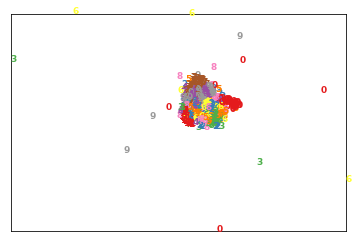

In [53]:

plot_embedding(X_tsne, targets[0:500])
plt.show()

### Finding optimal parameters
- heatmap with nb_neighbors and regr.value with accuracy in each point


In [62]:
grid_width = 4
nb_clusters = 10
nb_components = 2
nb_samples = 100
learning_rate_space=np.linspace(100,5000,grid_width, dtype=int)
perplexity_space = np.linspace(start=3, stop=80, num=grid_width, endpoint=True, dtype=int)

acc_list = np.zeros((grid_width,grid_width))

for i, perplexity in enumerate(perplexity_space):
    for j, lr in enumerate(learning_rate_space):
        
        tsne = manifold.TSNE(n_components=2, perplexity = perplexity, early_exaggeration = 4, learning_rate=lr, 
                     n_iter=1000, metric='euclidean', init='pca', verbose=0, random_state=0)
        X_tsne = tsne.fit_transform(inputs[0:nb_samples])

        kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, random_state=123).fit(X_tsne)
        acc = metrics.accuracy_score(targets[0:nb_samples], kmeans.labels_)
        acc_list[i, j] = acc



In [63]:
acc_list

array([[ 0.08,  0.03,  0.1 ,  0.06],
       [ 0.05,  0.1 ,  0.17,  0.13],
       [ 0.01,  0.16,  0.13,  0.16],
       [ 0.02,  0.06,  0.11,  0.14]])

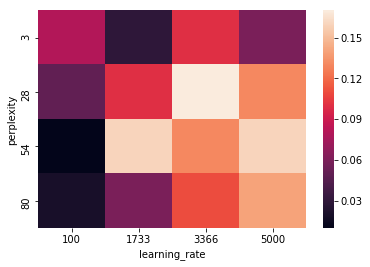

In [64]:
ax = sns.heatmap(acc_list)
ax.set_xlabel("learning_rate")
ax.set_ylabel("perplexity")
ax.set_xticklabels(learning_rate_space)
ax.set_yticklabels(perplexity_space)
plt.show()

## D. Comparison